In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

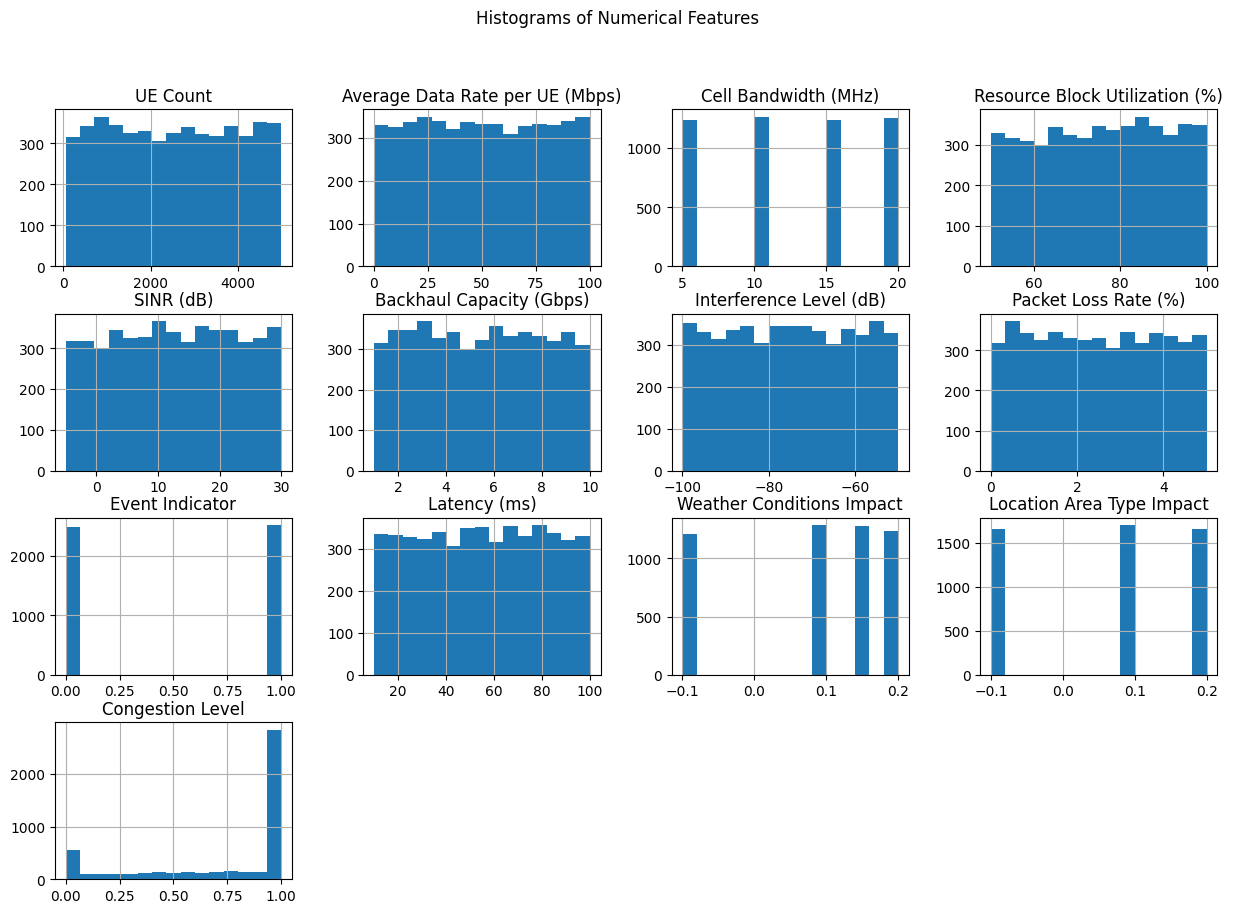

In [13]:
dataset = pd.read_excel('mobile_network_congestion_dataset.xlsx')

# Plot histograms for the dataset
dataset.hist(bins=15, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Features")
plt.show()


categorical_cols = dataset.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('Congestion Level')

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


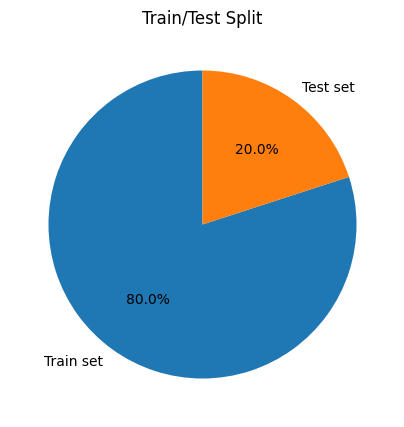

Linear Regression:
  Mean Absolute Error (MAE): 0.1607
  Mean Squared Error (MSE): 0.0367
  R-squared (R²): 0.7071



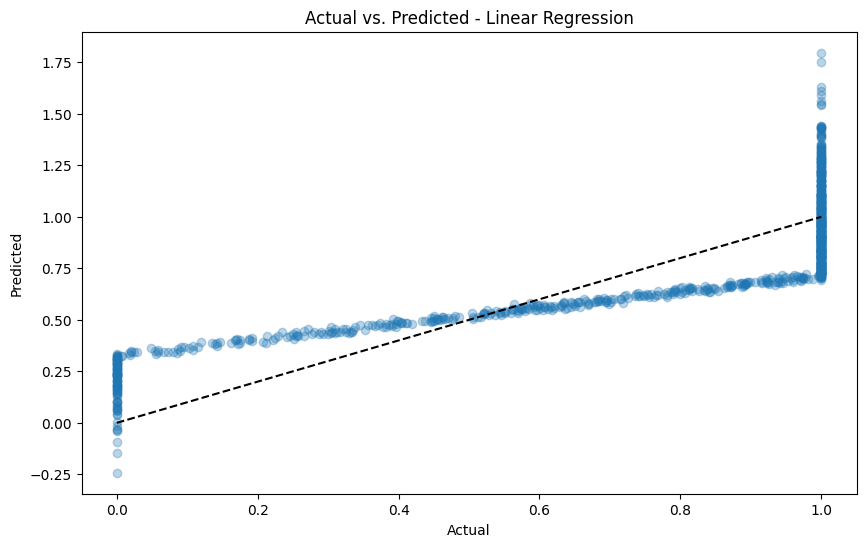

Random Forest:
  Mean Absolute Error (MAE): 0.1194
  Mean Squared Error (MSE): 0.0266
  R-squared (R²): 0.7877



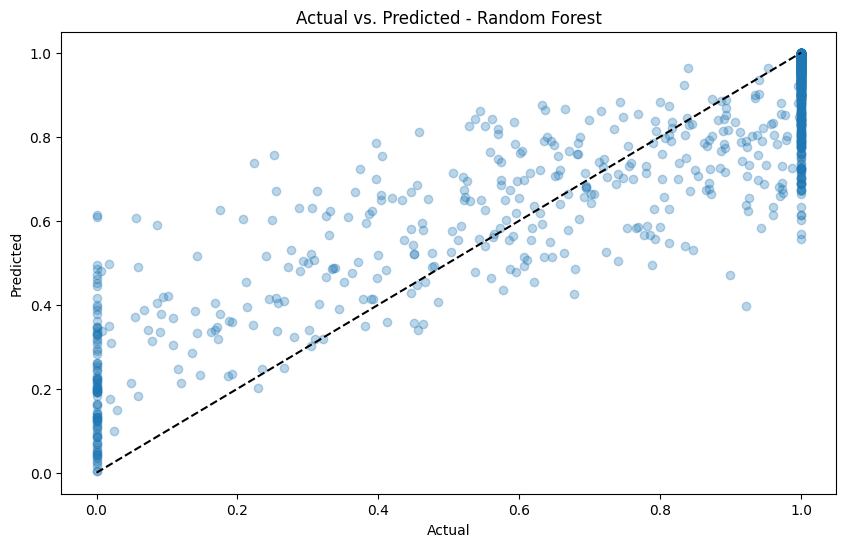

In [14]:

X = dataset.drop('Congestion Level', axis=1)
y = dataset['Congestion Level']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_test_split_sizes = [len(X_train), len(X_test)]
plt.figure(figsize=(5, 5))
plt.pie(train_test_split_sizes, labels=['Train set', 'Test set'], autopct='%1.1f%%', startangle=90)
plt.title('Train/Test Split')
plt.show()

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# models with all features
results_all_features = {}
for model_name, model in models.items():
   
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    # Evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results_all_features[model_name] = {'MAE': mae, 'MSE': mse, 'R2': r2}
    
   
    print(f"{model_name}:")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  R-squared (R²): {r2:.4f}\n")
    
    #  Actual vs Predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs. Predicted - {model_name}')
    plt.show()

Linear Regression with Selected Features:
  Mean Absolute Error (MAE): 0.1659
  Mean Squared Error (MSE): 0.0391
  R-squared (R²): 0.6882



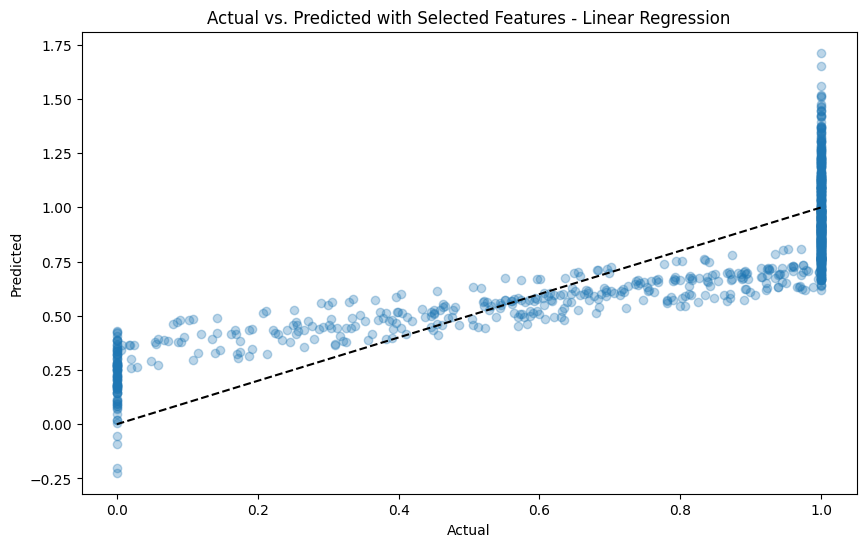

Random Forest with Selected Features:
  Mean Absolute Error (MAE): 0.1117
  Mean Squared Error (MSE): 0.0247
  R-squared (R²): 0.8029



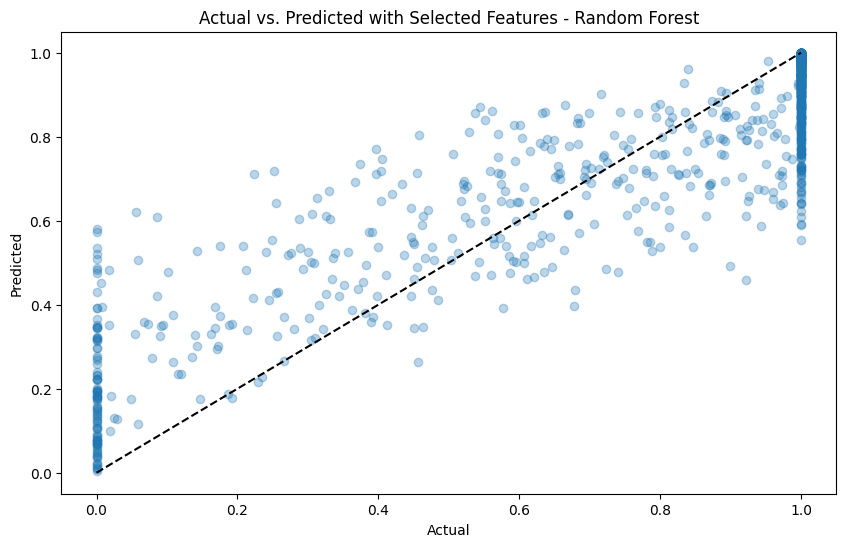

In [19]:
# Feature selection 
selector = SelectKBest(f_regression, k=10)

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

for model_name, model in models.items():
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', selector),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} with Selected Features:")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  R-squared (R²): {r2:.4f}\n")
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs. Predicted with Selected Features - {model_name}')
    plt.show()


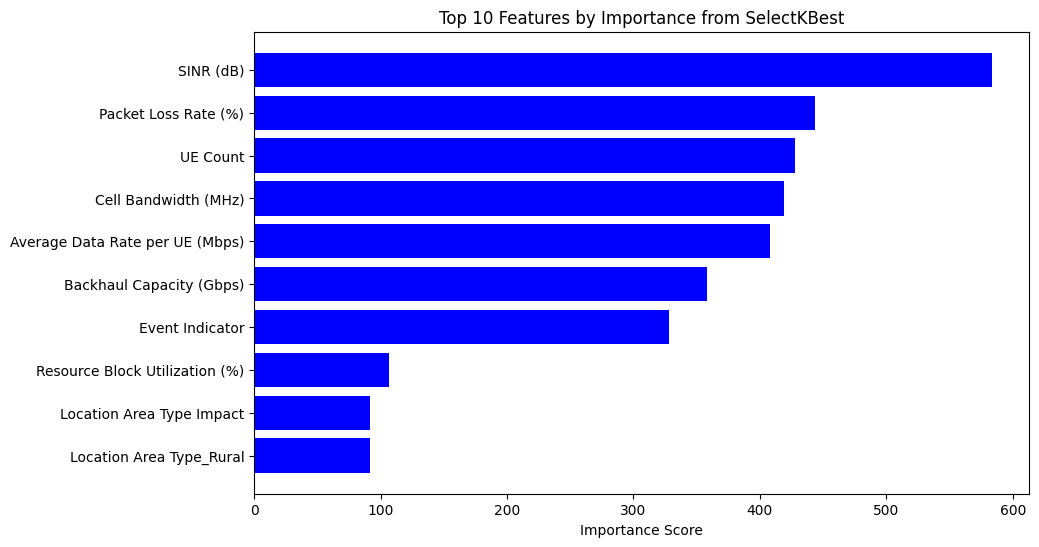

In [16]:
feature_importances = pipeline.named_steps['feature_selection'].scores_

# ColumnTransformer
num_features = preprocessor.transformers_[0][1].get_feature_names_out()
cat_features = preprocessor.transformers_[1][1].get_feature_names_out()
all_feature_names = np.concatenate((num_features, cat_features))

top_features_indices = np.argsort(feature_importances)[-10:]  
top_features_scores = feature_importances[top_features_indices]
top_features_names = all_feature_names[top_features_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features_names, top_features_scores, color='blue')
plt.xlabel('Importance Score')
plt.title('Top 10 Features by Importance from SelectKBest')
plt.show()